# Início

In [79]:
#IMPORTACOES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import plotly.figure_factory as ff
import copy

In [80]:
#salva o caminho dos datasets
dataset_a = "a_an_example.in.txt"
dataset_b = "b_better_start_small.in.txt"
dataset_c = "c_collaboration.in.txt"
dataset_d = "d_dense_schedule.in.txt"
dataset_e = "e_exceptional_skills.in.txt"
dataset_f = "f_find_great_mentors.in.txt"

# Leitura dos dados

In [81]:
def read_dataset(file_path):
    test_dataset = {
        'contributors': {},
        'projects': {},
    }
    num_c = None
    num_p = None

    with open(file_path, 'r') as file:
        lines = file.readlines()

    i = 0
    while i < len(lines):

        if i==0:
          line = lines[i].strip().split()
          num_c = int(line[0])
          num_p = int(line[0])+int(line[1])

        elif i<=num_c:
            line = lines[i].strip().split()
            contributor_name = line[0]
            contributor_numSkills = int(line[1])

            test_dataset['contributors'][contributor_name] = {
                'name': contributor_name,
                'skills': [],
                'skillsByName': {},
                'availableAt' : 0,
                'works': 0
            }

            for j in range(contributor_numSkills):
              i += 1
              num_c+=1
              num_p+=1
              line = lines[i].strip().split()

              skills = {'name': line[0], 'level': int(line[1])}
              skillsBN = {line[0] : int(line[1])}
              test_dataset['contributors'][contributor_name]['skills'].append(skills)
              test_dataset['contributors'][contributor_name]['skillsByName'].update(skillsBN)


        elif i<=num_p:
            line = lines[i].strip().split()
            project_name = line[0]
            project_numSkills = int(line[4])

            test_dataset['projects'][project_name] = {
                'name': project_name,
                'days': int(line[1]),
                'score': int(line[2]),
                'bestBefore': int(line[3]),
                'roles': [],
                'rolesByName': {}
            }

            for j in range(project_numSkills):
              i += 1
              num_c+=1
              num_p+=1
              line = lines[i].strip().split()

              roles = {'name': line[0], 'levelRequired': int(line[1])}
              rolesBN = {line[0] : int(line[1])}
              test_dataset['projects'][project_name]['roles'].append(roles)
              test_dataset['projects'][project_name]['rolesByName'].update(rolesBN)

        i += 1
    return test_dataset

dataset_A = read_dataset(dataset_a)
dataset_B = read_dataset(dataset_b)
dataset_C = read_dataset(dataset_c)
dataset_D = read_dataset(dataset_d)
dataset_E = read_dataset(dataset_e)
dataset_F = read_dataset(dataset_f)

# Solver

In [82]:
# Pega uma variável de conjunto de dados e retorna uma variável de solução
def solve(dataset, priority_order, contributor_order):
    plotx = [ 0 ]
    ploty = [ len(dataset['projects'].values()) ]
    for contributor in dataset['contributors'].values():
        contributor['availableAt'] = 0

    totalScore = 0
    lastDay = max(proj['bestBefore'] + proj['score'] for proj in dataset['projects'].values())

    solution = {'projects': []}
    selectedProjectNames = set()
    currentTime = 0
    projectOrder = []

    if(priority_order=="SPT"):
      for project in dataset['projects'].values():
        spt = project['days']
        projectOrder.append((spt, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="LPT"):
      for project in dataset['projects'].values():
        spt = project['days']
        projectOrder.append((spt, project['name']))
      projectOrder.sort(reverse=True)

    elif(priority_order=="EDD"):
      for project in dataset['projects'].values():
        edd = project['bestBefore']
        projectOrder.append((edd, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="MST"):
      for project in dataset['projects'].values():
        mst = max(0, project['days'] + project['bestBefore'])
        projectOrder.append((mst, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="CR"):
      for project in dataset['projects'].values():
        cr = max(0, project['bestBefore'] // project['days'])
        projectOrder.append((cr, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="SLACK"):
      for project in dataset['projects'].values():
        slack = max(0, project['bestBefore'] - currentTime - project['days'])
        projectOrder.append((slack, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="MANPOWER"):
      for project in dataset['projects'].values():
        penalty = max(0, currentTime + project['days'] - project['bestBefore'])
        realScore = max(0, project['score'] - penalty)
        manpower = project['days'] * len(project['roles'])
        score = max(0, project['score'] - penalty) / manpower
        projectOrder.append((score, project['name']))
      projectOrder.sort(reverse=False)


    while True:
        projectScores = []
        for _, projectName in projectOrder:
            project = dataset['projects'][projectName]
            if project['name'] in selectedProjectNames:
                continue # não selecione um projeto duas vezes

            penalty = max(0, currentTime + project['days'] - project['bestBefore'])
            realScore = max(0, project['score'] - penalty)

            manpower = project['days'] * len(project['roles'])
            score = max(0, project['score'] - penalty) / manpower


            selectedPpl = []
            selectedContribs = set()
            rolesCanBeMentored = set()
            for roleDict in project['roles']:
                roleName = roleDict['name']
                roleLevel = roleDict['levelRequired']
                contribselect = []
                ordr = list(dataset['contributors'].values())
                random.shuffle(ordr)
                for contributor in ordr:
                  if(contributor_order=="First_to_find"):
                    if (contributor['availableAt'] <= currentTime and
                        contributor['name'] not in selectedContribs):
                        if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                            contribselect.append((500 - contributor['works'], contributor['name']))
                            break
                        elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                            contribselect.append((500 - contributor['works'], contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                            #contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))
                            contribselect.append((  - contributor['works'] , contributor['name']))


                  elif(contributor_order=="Nearest"):
                    if (contributor['availableAt'] <= currentTime and
                        contributor['name'] not in selectedContribs):
                        if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                            contribselect.append((500-(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                            contribselect.append((500-(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                            contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))

                  elif(contributor_order=="Farest"):
                    if (contributor['availableAt'] <= currentTime and
                        contributor['name'] not in selectedContribs):
                        if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                            contribselect.append((500+(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                            contribselect.append((500+(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                            contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))

                if len(contribselect) == 0:
                    # Não encontrou um colaborador adequado nesta data
                    score = -1
                    break
                else:
                    bestContribScore, bestContribName = max(contribselect)
                    selectedPpl.append(bestContribName)
                    selectedContribs.add(bestContribName)

                    for role in project['roles']:
                        roleName = role['name']
                        roleLevel = role['levelRequired']
                        if dataset['contributors'][bestContribName]['skillsByName'].get(roleName,0) >= roleLevel:
                            rolesCanBeMentored.add(roleName)

            projectScores.append((score, realScore, project['name'], selectedPpl))
            if score > 0:
                # Encontrou uma pontuação válida
                # Como estamos verificando diminuindo a pontuação esperada, podemos quebrar agora
                break

        if(len(projectScores)!=0):
          bestScore, bestRealScore, bestProjectName, bestAlloc = max(projectScores)
          ##################################print(f'Melhor pontuacao do projeto: {bestScore:.2f} / {bestRealScore}. Total {totalScore}')
        else:
          bestScore, bestRealScore, bestProjectName, bestAlloc = (-1,-1,-1,-1)

        if bestScore > 0:
            totalScore += bestRealScore
            ##################################print(f"{len(dataset['projects']) - len(selectedProjectNames)} projetos faltantes.")
            bestProject = dataset['projects'][bestProjectName]
            for name, role in zip(bestAlloc, bestProject['roles']):
                contributor = dataset['contributors'][name]
                contributor['availableAt'] = currentTime + bestProject['days']
                contributor['works'] = contributor['works'] + 1

                # Level up
                contributorSkill = contributor['skillsByName'].get(role['name'], 0)
                if contributorSkill <= role['levelRequired']:
                    assert contributorSkill >= role['levelRequired'] - 1
                    contributor['skillsByName'][role['name']] = contributorSkill + 1

            projectSol = {
                'name': bestProjectName,
                'roles': bestAlloc,
                'startTime': currentTime
            }
            #print(projectSol)
            solution['projects'].append(projectSol)
            selectedProjectNames.add(bestProjectName)

        if bestScore <= 0:
            # Avance no tempo

            earliestStep = lastDay
            for contributor in dataset['contributors'].values():
                if contributor['availableAt'] > currentTime:
                    earliestStep = min(earliestStep, contributor['availableAt'])
            currentTime = earliestStep
            plotx.append(currentTime)
            ploty.append(len(dataset['projects']) - len(selectedProjectNames))
            ##################################print(f'Avança no tempo para {currentTime}/{lastDay}')
            if currentTime >= lastDay:
                break

    maxday = lastDay
    len_incompleted_projects = len(dataset['projects']) - len(selectedProjectNames)
    incompleted_projects = {key: value for key, value in dataset['projects'].items() if key not in selectedProjectNames}


    return incompleted_projects, maxday, solution, totalScore, plotx, ploty

# Impressão dos gráficos

In [83]:
def imprime(p_x, p_y):
    plt.figure(figsize=(20, 5))
    plt.bar([str(x) for x in p_x], p_y)
    plt.ylim(0, p_y[0])
    #plt.xlabel('X-axis Label')
    #plt.ylabel('Y-axis Label')
    #ax.margins(x=0)
    plt.title("Dia x Projetos Incompletos")
    plt.margins(x=0)
    plt.xticks(rotation=270)

    plt.show()
    
    
def plota_graficos(dataset, incompleted_projects, maxday, solution, totalScore, plotx, ploty, priority_order, contributor_order):
    trocas_c = 0
    trocas_p = 0
    for projectName in incompleted_projects:
        project = dataset['projects'][projectName]
        selectedPpl = []
        selectedContribs = set()
        rolesCanBeMentored = set()
        missing_roles = []
        for roleDict in project['roles']:
          roleName = roleDict['name']
          roleLevel = roleDict['levelRequired']
          contribselect = []
          ordr = list(dataset['contributors'].values())
          for contributor in ordr:
            if (contributor['name'] not in selectedContribs):
                if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                    and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                    contribselect.append((1000, contributor['name']))
                    break
                elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                    contribselect.append((500, contributor['name']))
                elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                    contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))

          if len(contribselect) == 0:
              maximum = 0
              for contributor in ordr:
                if contributor['skillsByName'].get(roleName, 0) > maximum:
                  maximum = contributor['skillsByName'].get(roleName, 0)
              missing_roles.append((projectName, roleName, "roleLevel:", roleLevel, "max_value_found:", maximum))
              if (maximum>=roleLevel):
                trocas_c+=1
              else:
                trocas_p+=1
          else:
              bestContribScore, bestContribName = max(contribselect)
              selectedPpl.append(bestContribName)
              selectedContribs.add(bestContribName)

              for role in project['roles']:
                  roleName = role['name']
                  roleLevel = role['levelRequired']
                  if dataset['contributors'][bestContribName]['skillsByName'].get(roleName,0) >= roleLevel:
                      rolesCanBeMentored.add(roleName)
        print(len(missing_roles))
        for mr in missing_roles:
          print(mr)
    if(True):
      print("Poderia fazer", trocas_c, "trocas da ordem de contribuidores")
      print("Poderia fazer", trocas_p, "trocas da ordem dos projetos")
      xxx = []
      yyy = []
      ordr = list(dataset['contributors'].values())
      for contributor in ordr:
        xxx.append(contributor['name'])
        yyy.append(contributor['works'])

      plt.figure(figsize=(20, 5))
      plt.bar(xxx, yyy)
      #plt.ylim(0, p_y[0])
      #plt.xlabel('X-axis Label')
      #plt.ylabel('Y-axis Label')
      #ax.margins(x=0)
      plt.title("Numero de vezes que cada contribuidor foi selecionado para"+contributor_order)
      plt.margins(x=0)
      plt.xticks(rotation=270)

      plt.show()



##################################
##################################
##################################

(27, 37740, 'B', 'First_to_find', 'SPT', 800946)


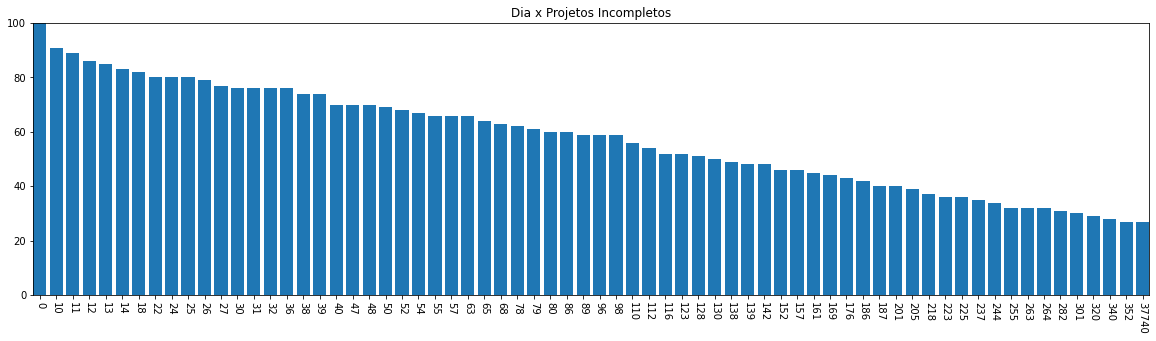

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
3
('GlassOSProv9', 'CloudComputing++', 'roleLevel:', 6, 'max_value_found:', 9)
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'role

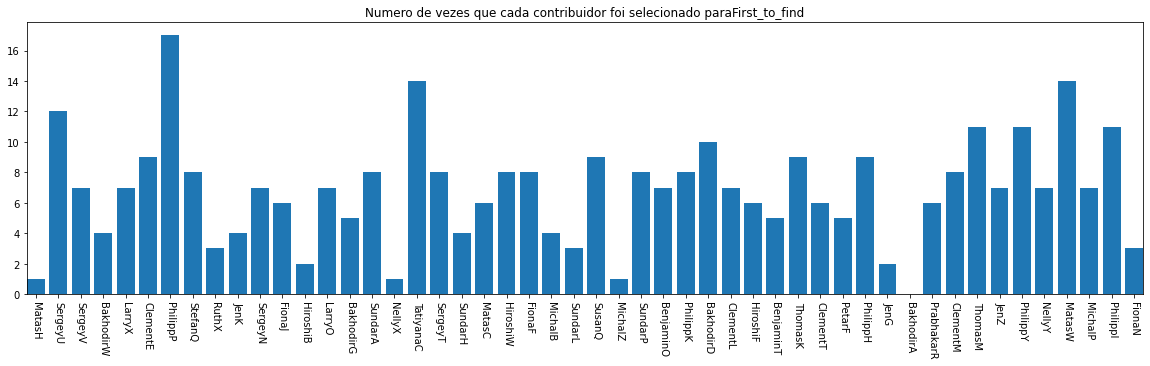

(27, 37740, 'B', 'Nearest', 'SPT', 800991)


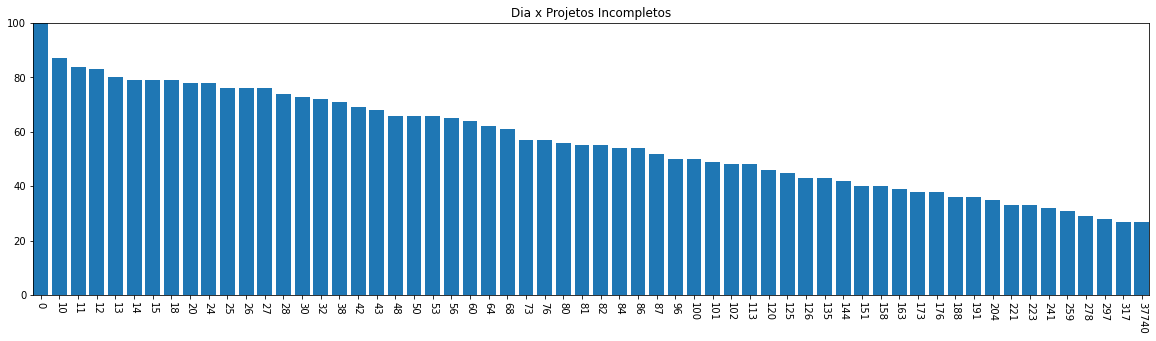

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0',

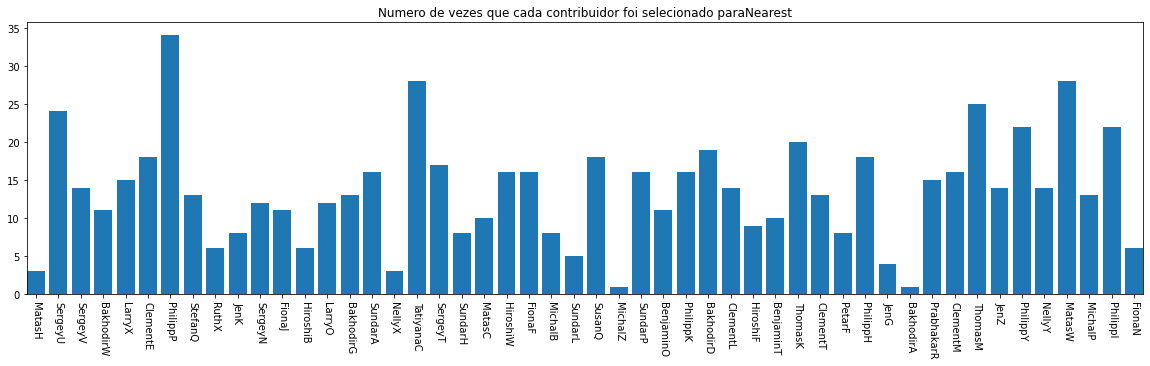

(28, 37740, 'B', 'Farest', 'SPT', 769472)


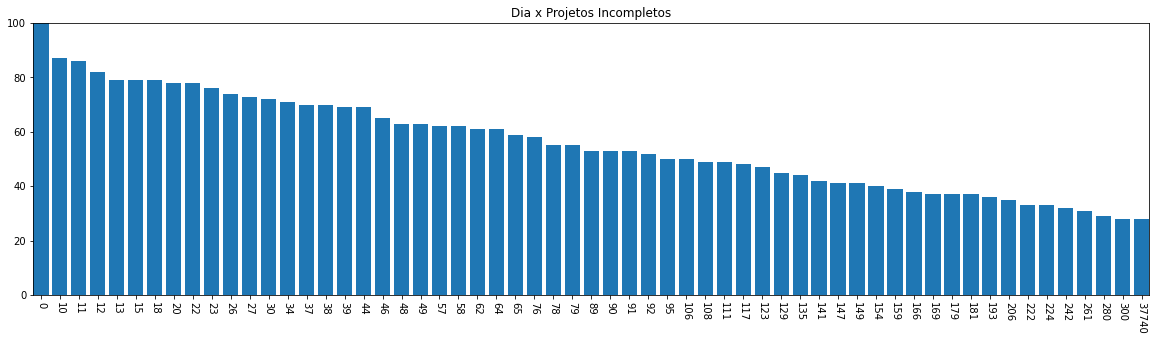

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('CastOSNextv8', 'Assembly-py', 'roleLev

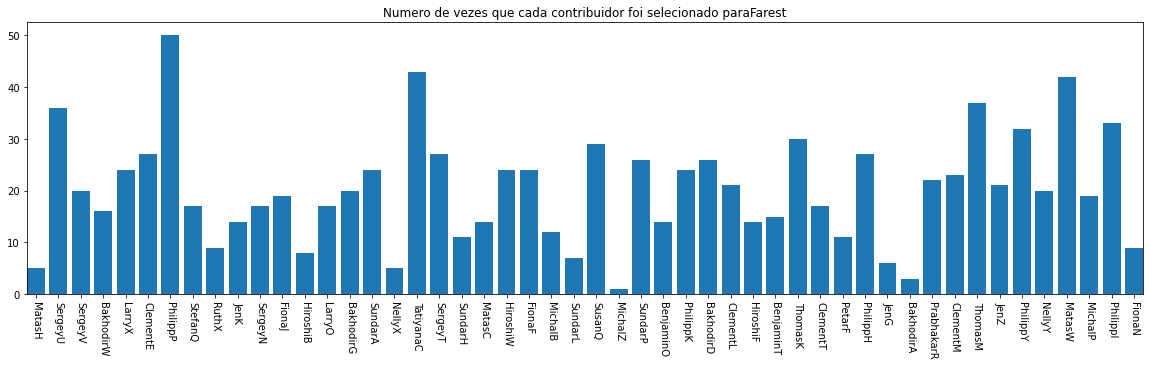

(27, 37740, 'B', 'First_to_find', 'LPT', 800991)


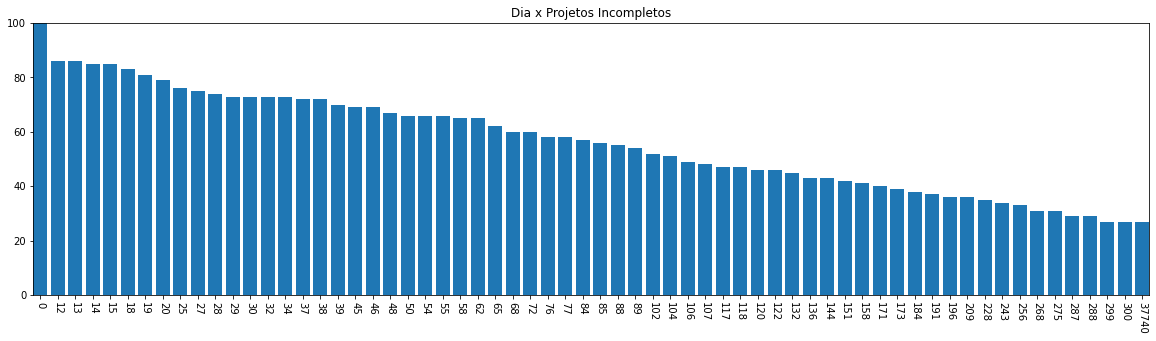

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0',

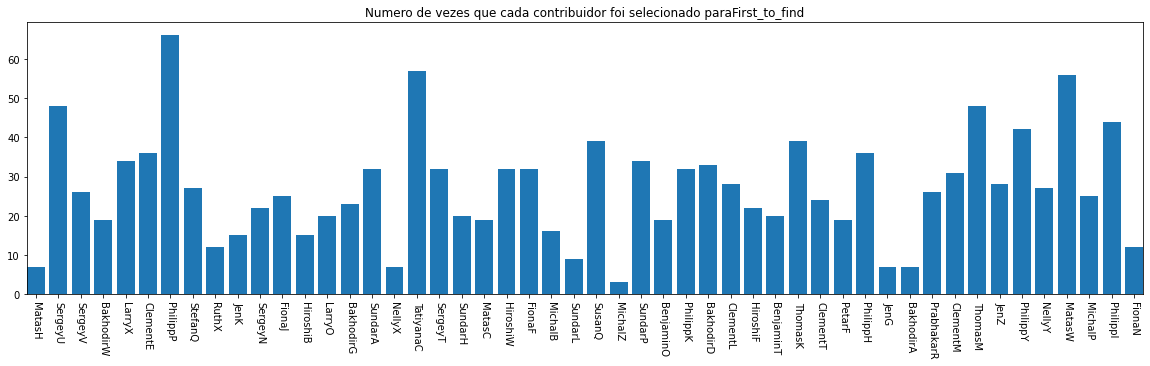

(28, 37740, 'B', 'Nearest', 'LPT', 769472)


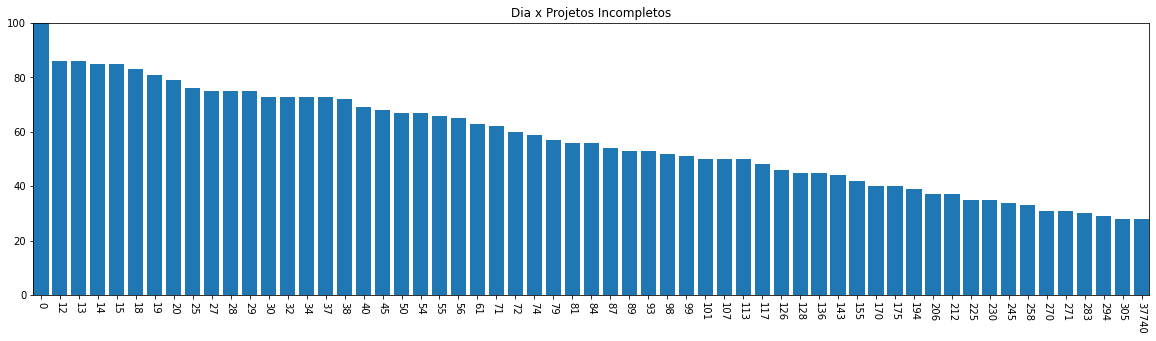

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('CastOSNextv8', 'Dart', 'roleLevel:', 4

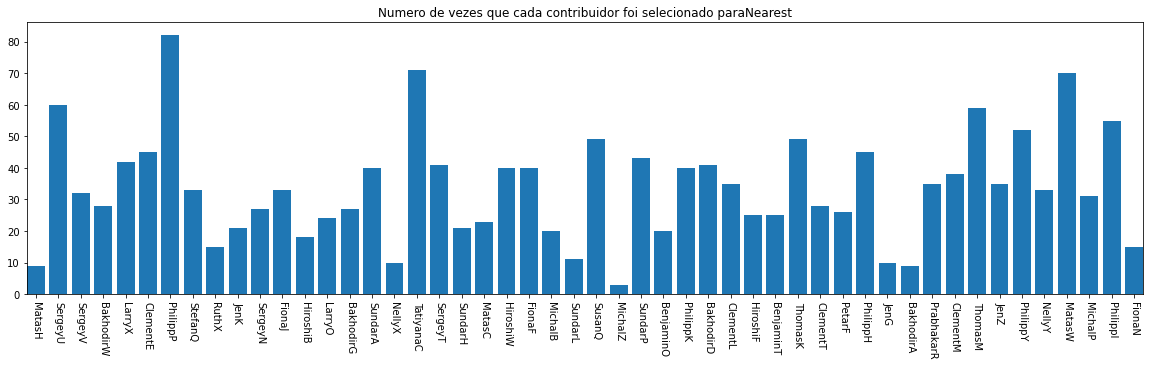

(27, 37740, 'B', 'Farest', 'LPT', 800991)


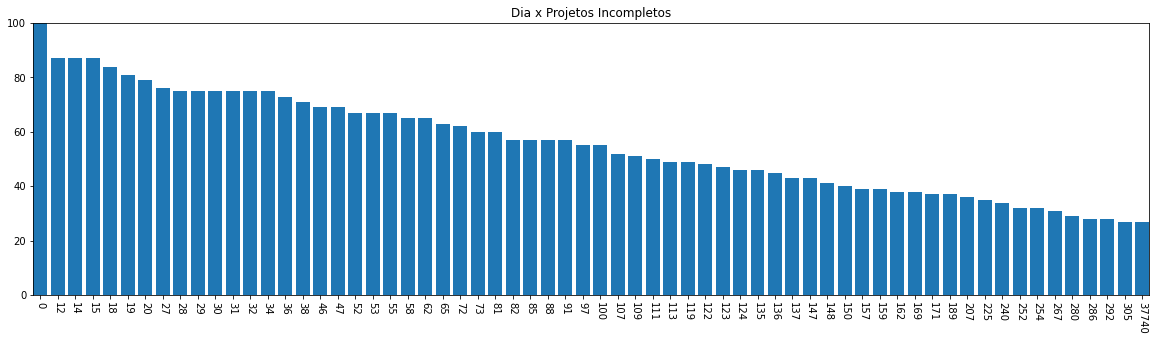

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0',

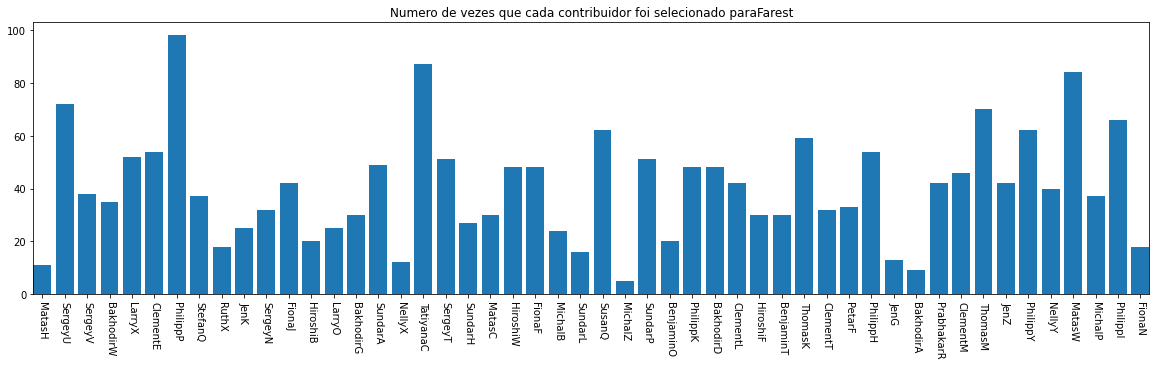

(27, 37740, 'B', 'First_to_find', 'EDD', 800991)


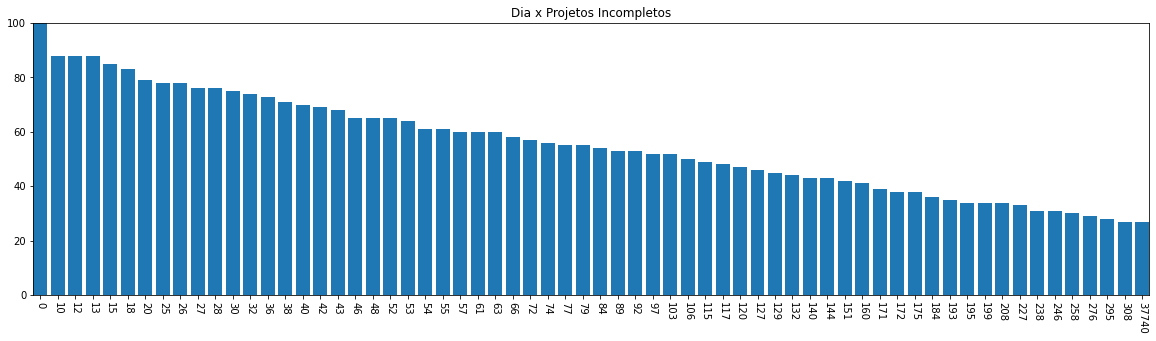

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0',

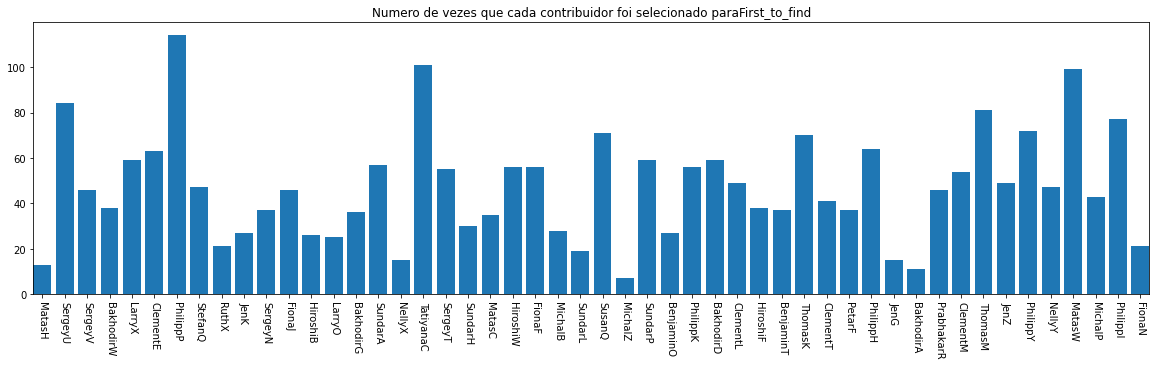

(30, 37740, 'B', 'Nearest', 'EDD', 735534)


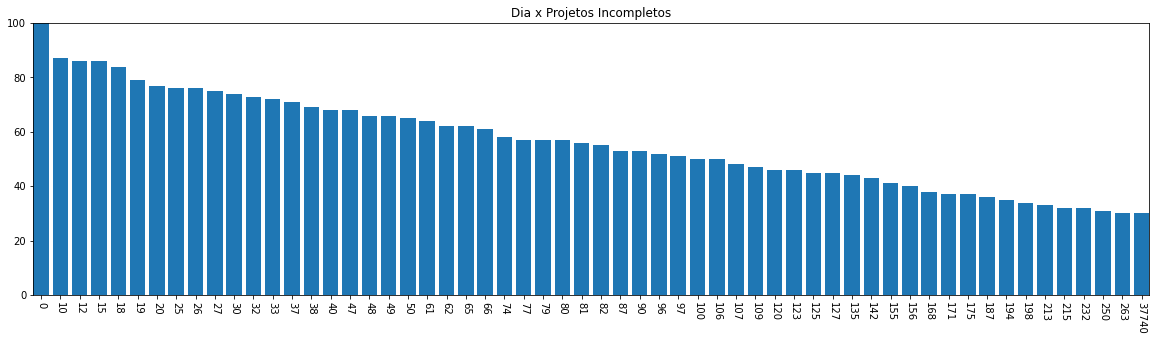

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
2
('DrawingsXv6', 'MachineLearning-2+0', 'roleLevel:', 6, 'max_value_found:', 5)
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 5)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('CastOSNextv8', 'Assembly-py', 'roleLev

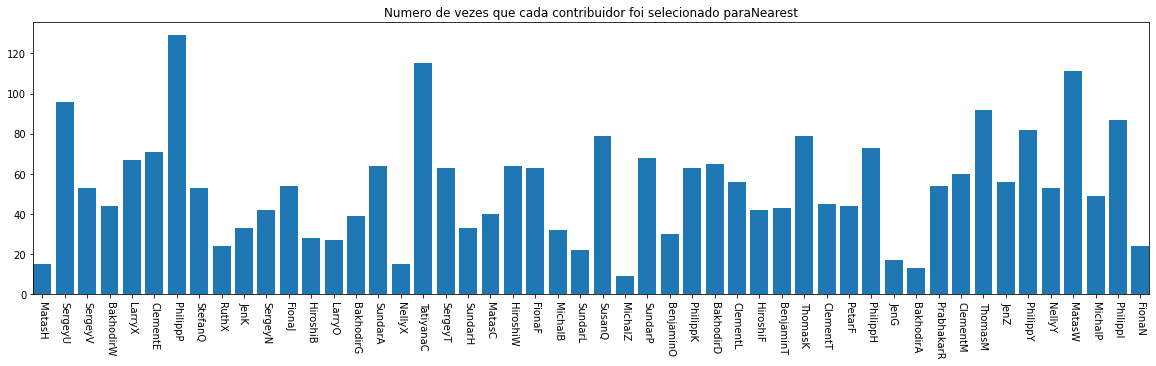

(25, 37740, 'B', 'Farest', 'EDD', 824111)


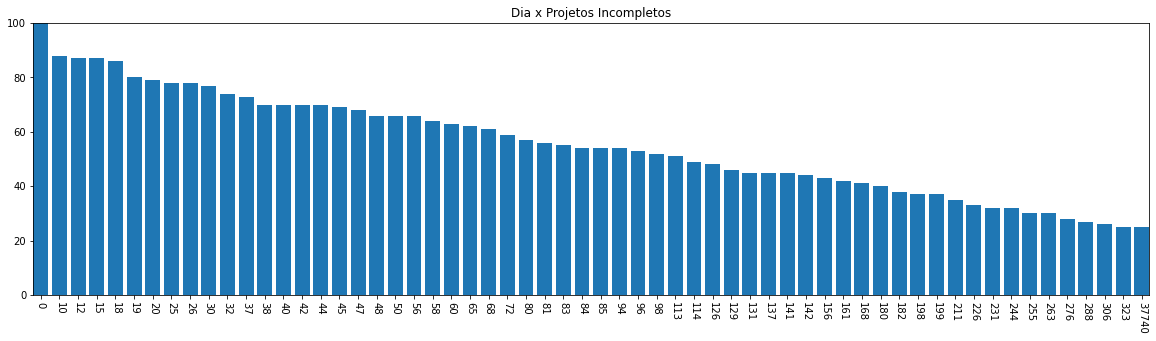

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('CastOSNextv8', 'Assembly-py', 'roleLevel:', 6, 'max_value_found:', 8)
2
('ResearchUltrav8', 'Communication-3+0', 'rol

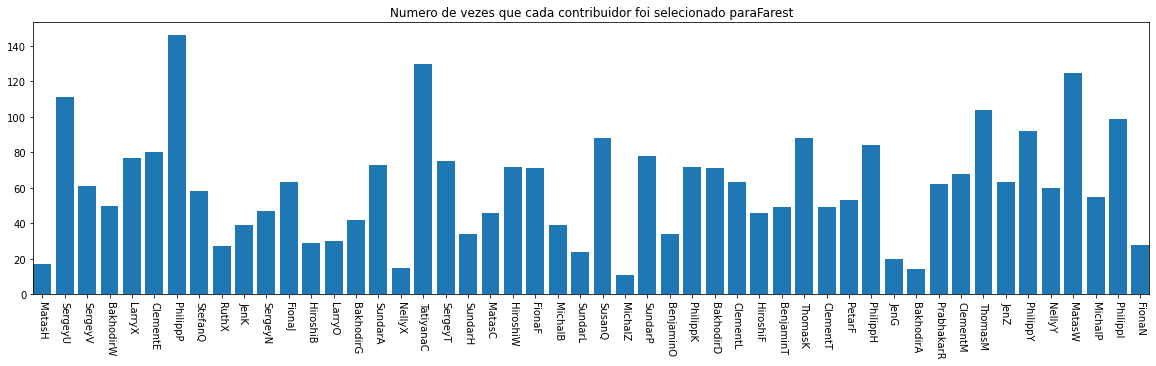

(24, 37740, 'B', 'First_to_find', 'MST', 855630)


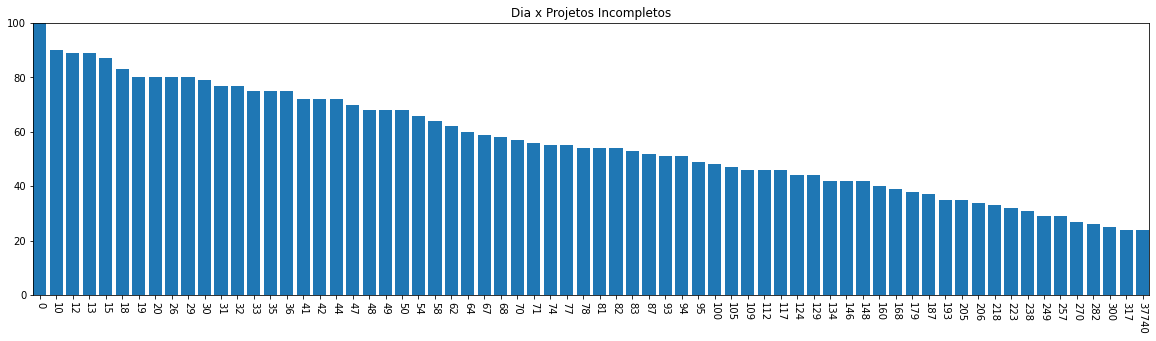

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', 'roleLevel:', 8, 'max_value_found:', 7)
('ResearchUltrav8', 'CloudComputing-NE

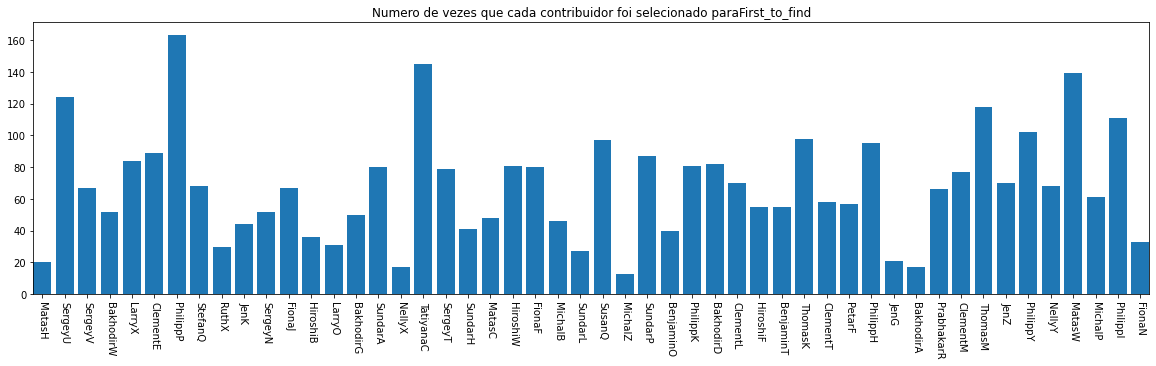

(25, 37740, 'B', 'Nearest', 'MST', 824111)


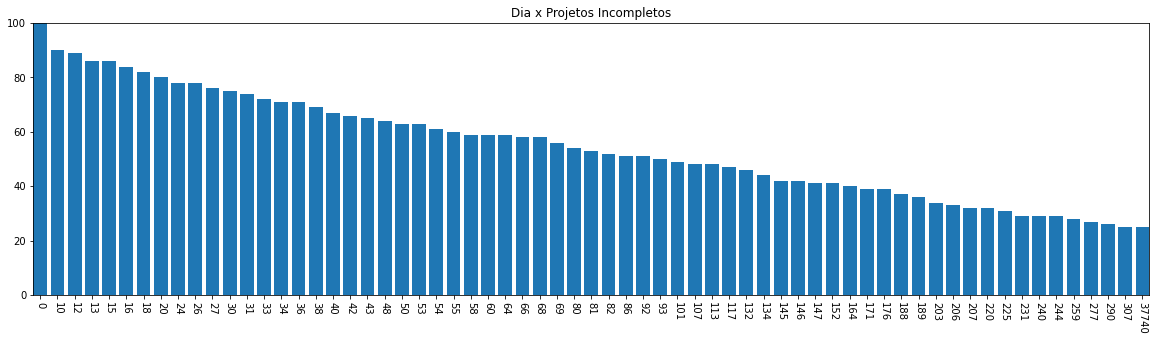

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('CastOSNextv8', 'Assembly-py', 'roleLevel:', 6, 'max_value_found:', 8)
2
('ResearchUltrav8', 'Communication-3+0', 'rol

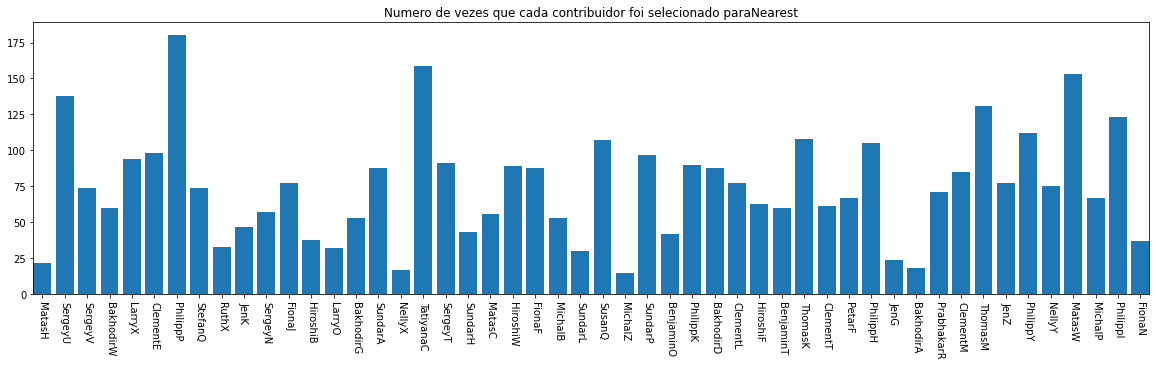

(25, 37740, 'B', 'Farest', 'MST', 824111)


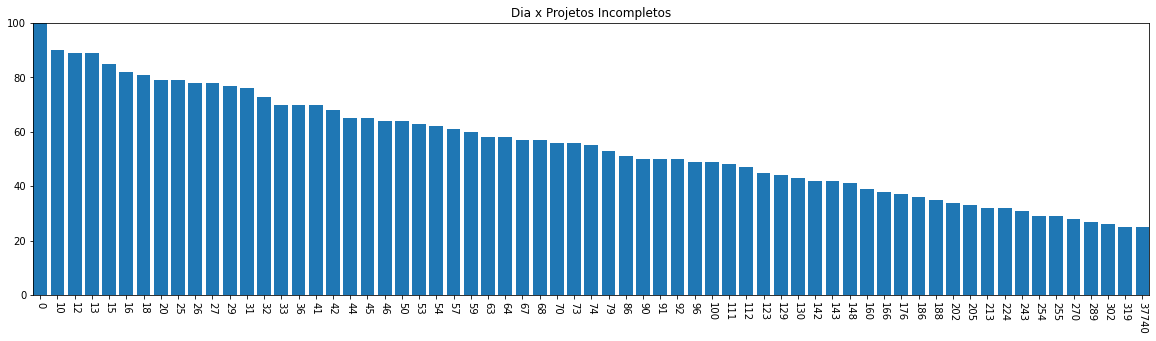

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('CastOSNextv8', 'Assembly-py', 'roleLevel:', 6, 'max_value_found:', 8)
2
('ResearchUltrav8', 'Communication-3+0', 'rol

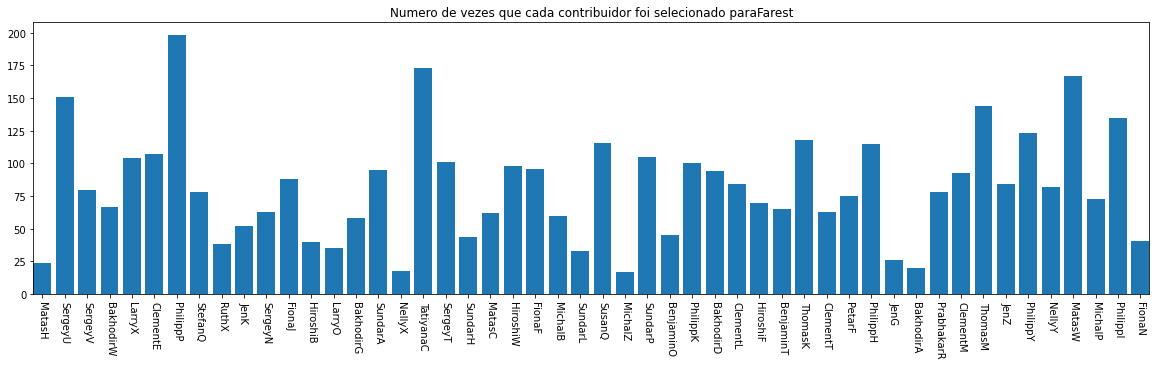

(24, 37740, 'B', 'First_to_find', 'CR', 855630)


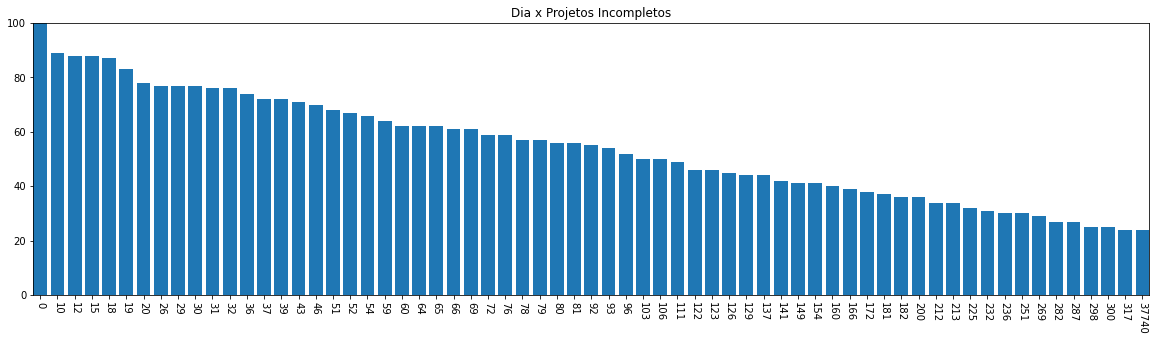

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', 'roleLevel:', 8, 'max_value_found:', 7)
('ResearchUltrav8', 'CloudComputing-NE

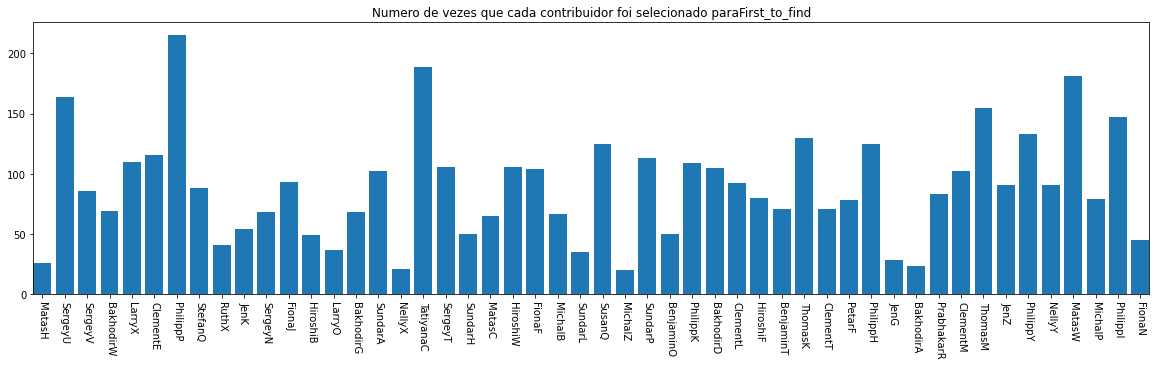

(25, 37740, 'B', 'Nearest', 'CR', 843133)


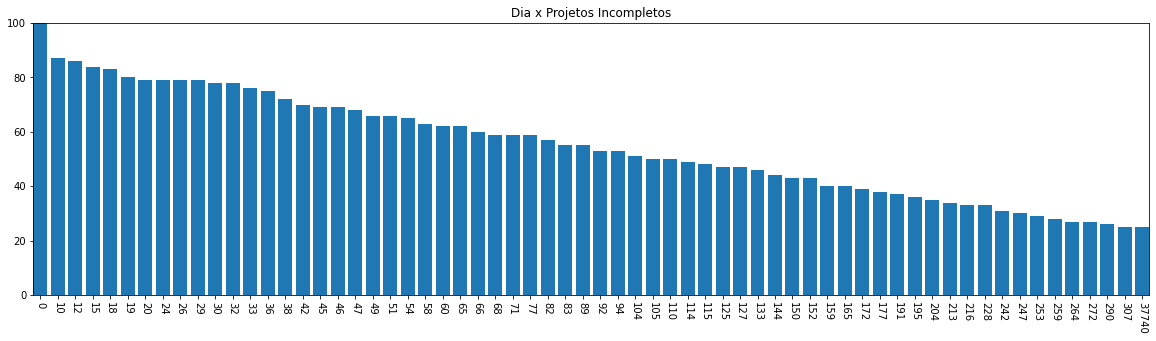

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('AndroidTVNextv1', 'Assembly-py', 'roleLevel:', 3, 'max_value_found:', 8)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', '

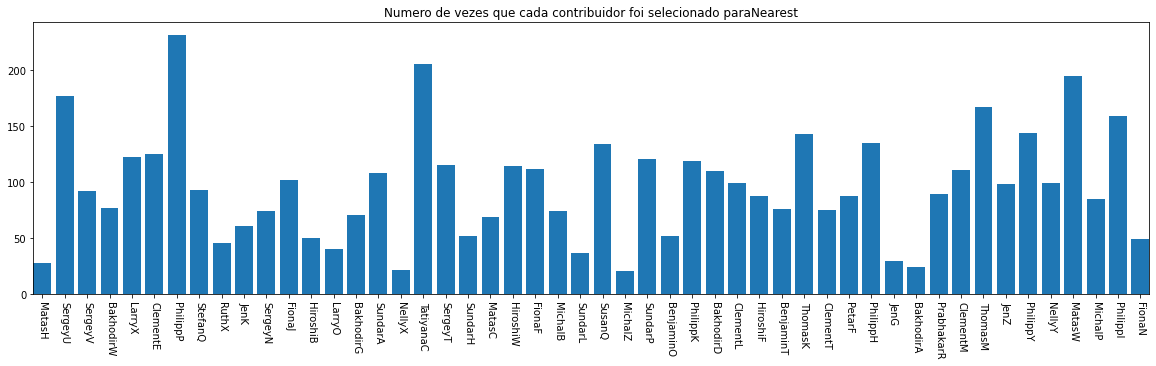

(24, 37740, 'B', 'Farest', 'CR', 855630)


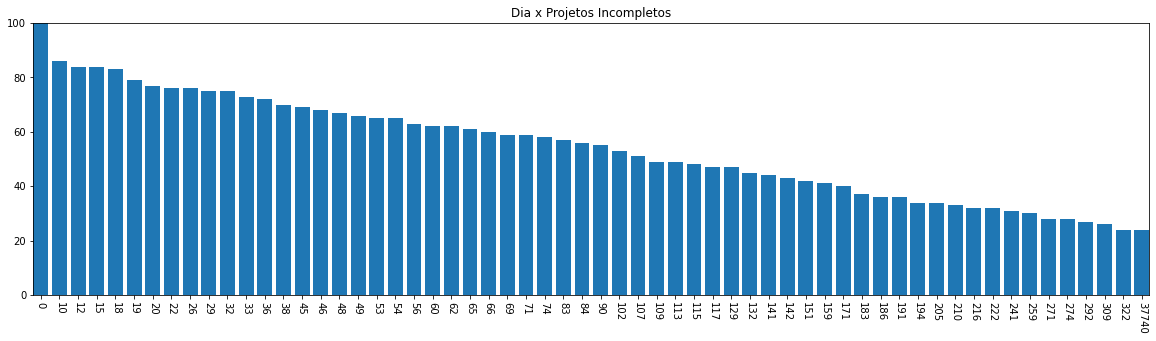

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', 'roleLevel:', 8, 'max_value_found:', 7)
('ResearchUltrav8', 'CloudComputing-NE

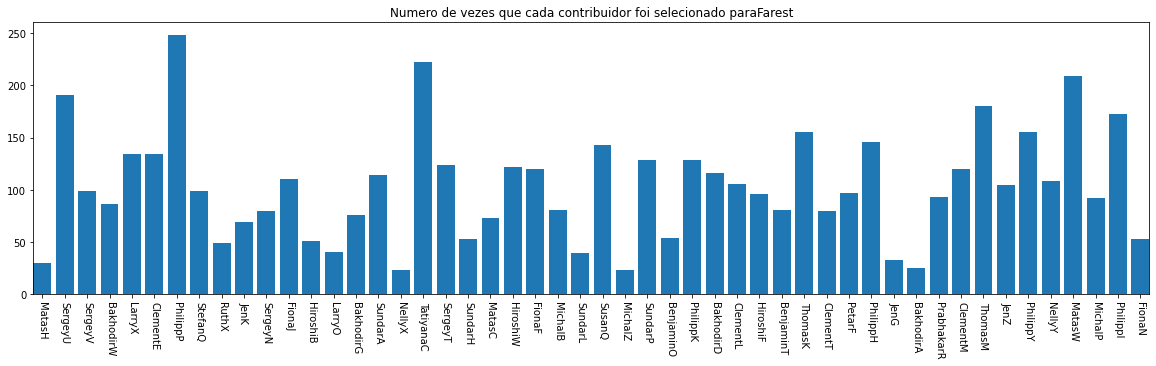

(24, 37740, 'B', 'First_to_find', 'SLACK', 855630)


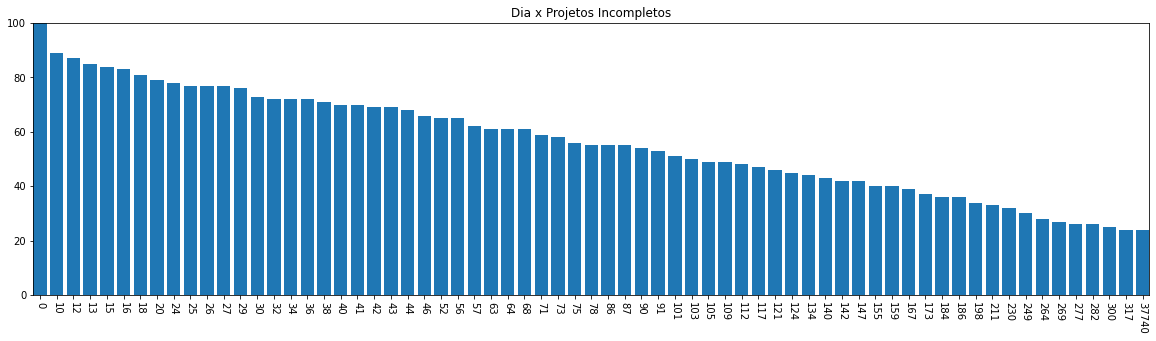

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', 'roleLevel:', 8, 'max_value_found:', 7)
('ResearchUltrav8', 'CloudComputing-NE

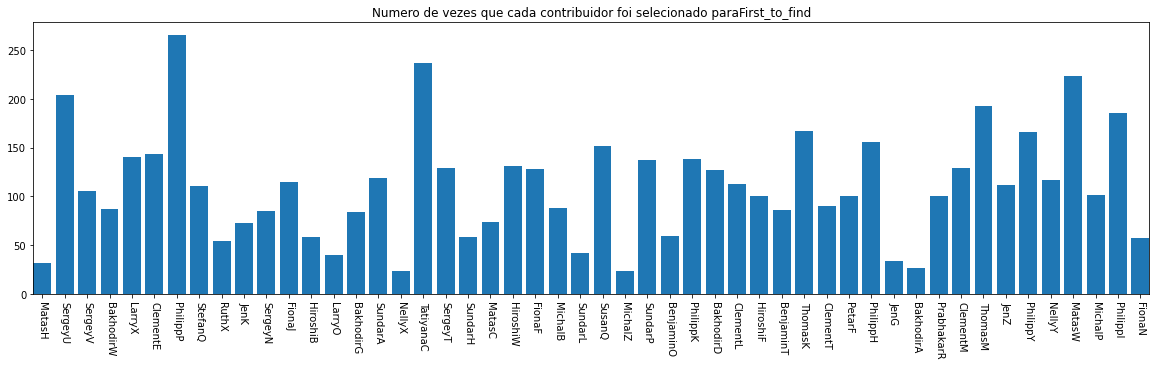

(24, 37740, 'B', 'Nearest', 'SLACK', 855630)


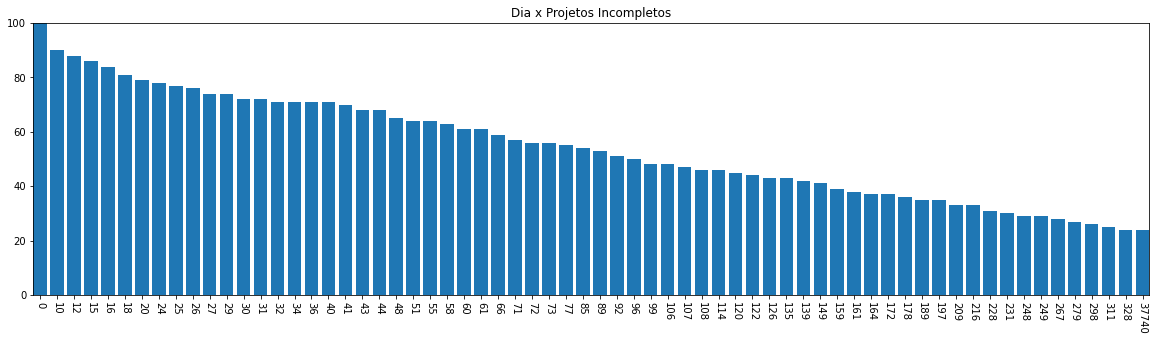

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', 'roleLevel:', 8, 'max_value_found:', 7)
('ResearchUltrav8', 'CloudComputing-NE

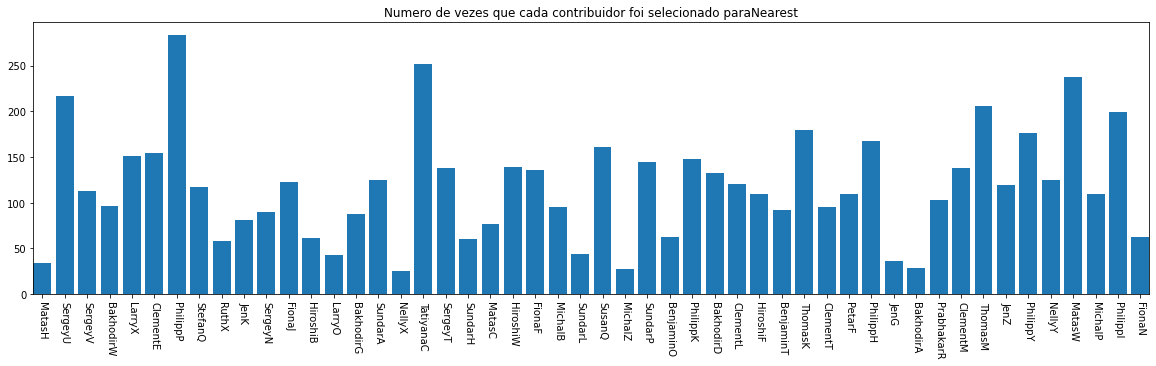

(25, 37740, 'B', 'Farest', 'SLACK', 843133)


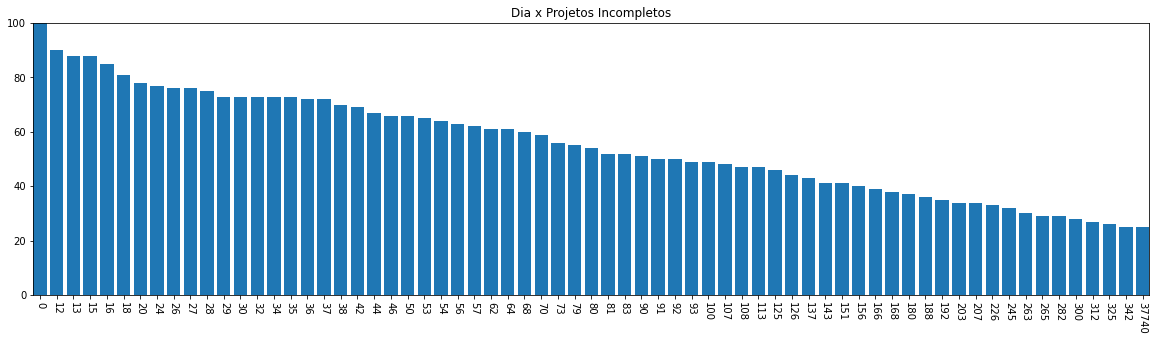

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('AndroidTVNextv1', 'JavaScript-NET', 'roleLevel:', 2, 'max_value_found:', 5)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0'

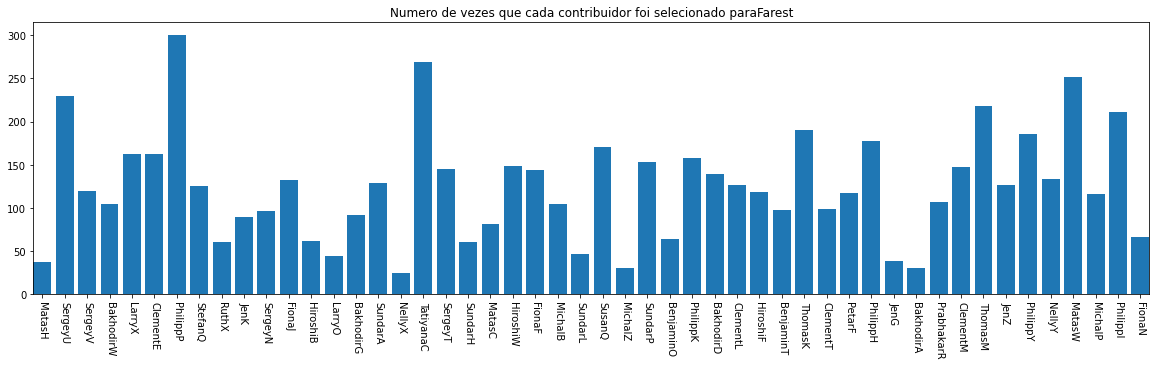

(24, 37740, 'B', 'First_to_find', 'MANPOWER', 855630)


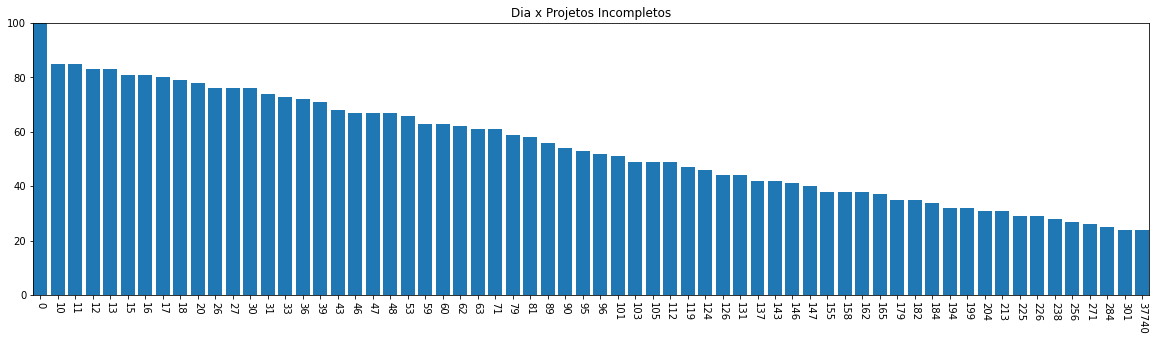

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', 'roleLevel:', 8, 'max_value_found:', 7)
('ResearchUltrav8', 'CloudComputing-NE

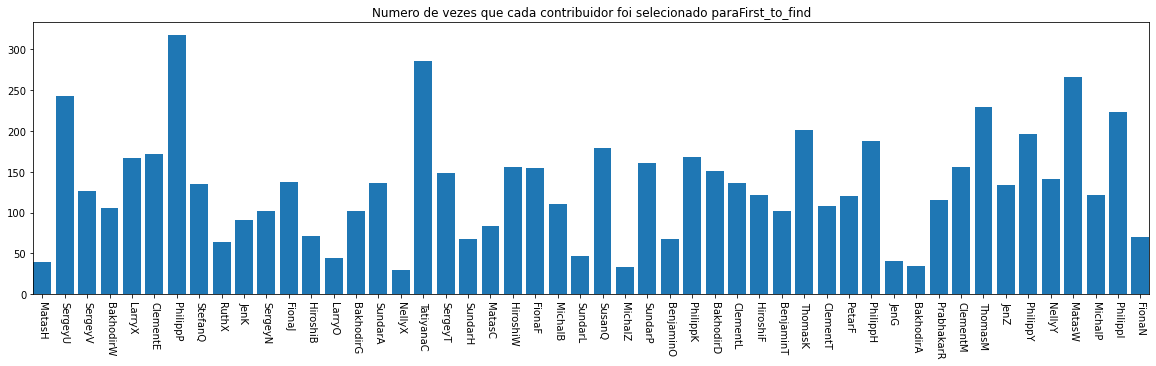

(25, 37740, 'B', 'Nearest', 'MANPOWER', 843133)


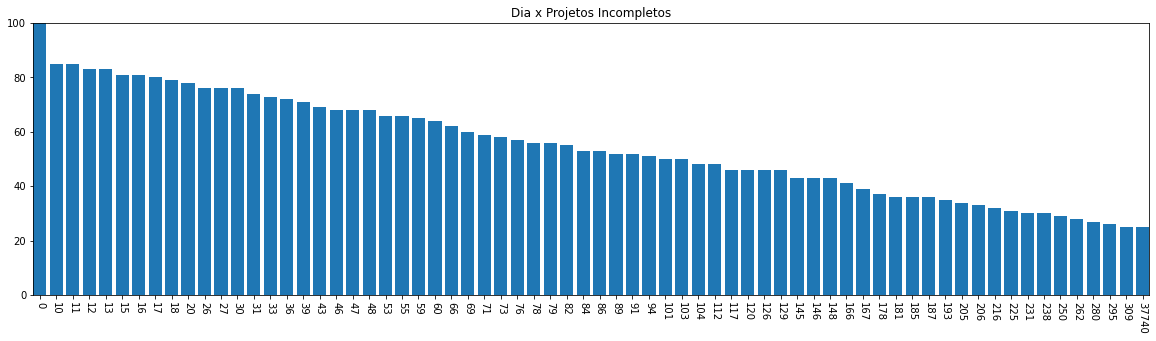

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('AndroidTVNextv1', 'Angular-NET', 'roleLevel:', 2, 'max_value_found:', 9)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', '

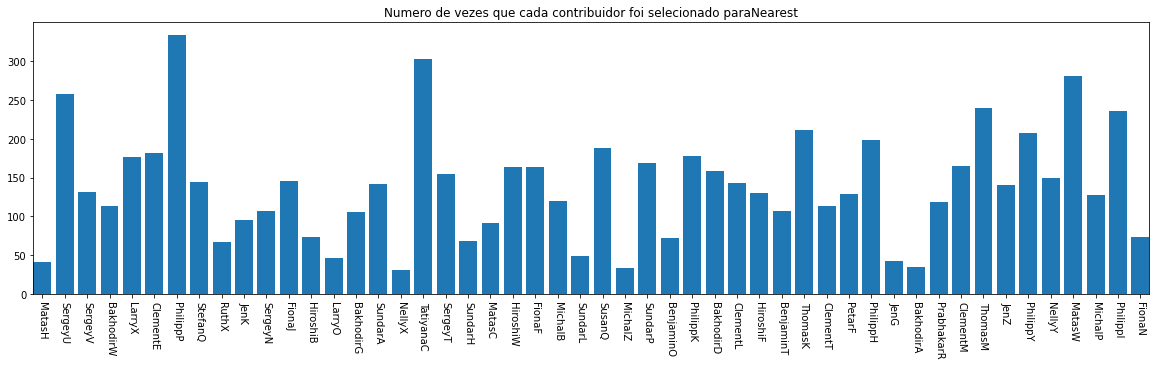

(24, 37740, 'B', 'Farest', 'MANPOWER', 850048)


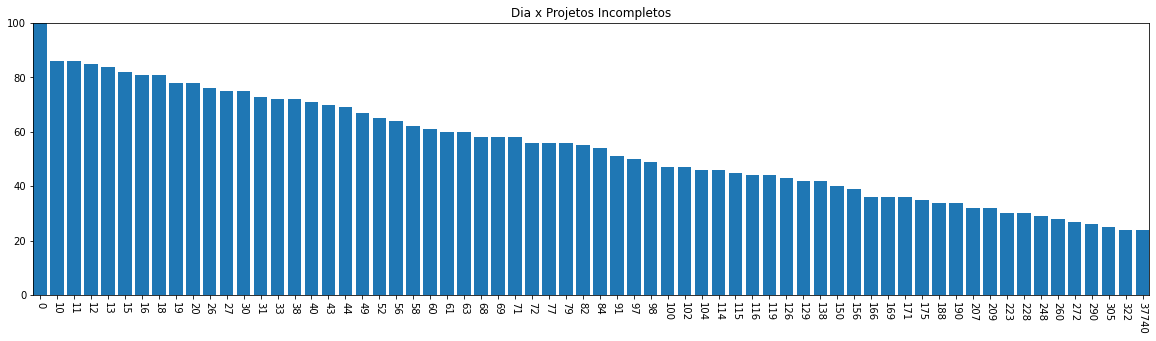

2
('StadiaNextv9', 'Go-NET', 'roleLevel:', 9, 'max_value_found:', 8)
('StadiaNextv9', 'Blockchain', 'roleLevel:', 9, 'max_value_found:', 12)
1
('AndroidTVNextv1', 'Angular-NET', 'roleLevel:', 2, 'max_value_found:', 9)
1
('DrawingsXv6', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
1
('DuoLitev3', 'MATLAB', 'roleLevel:', 6, 'max_value_found:', 5)
1
('LoggingLitev6', 'Delphi', 'roleLevel:', 4, 'max_value_found:', 8)
1
('ChatProv6', 'Go-NET', 'roleLevel:', 8, 'max_value_found:', 8)
1
('FeedBurnerNextv3', 'MachineLearning-2+0', 'roleLevel:', 5, 'max_value_found:', 7)
1
('AndroidTVXv9', 'HTML-js', 'roleLevel:', 2, 'max_value_found:', 9)
2
('GlassOSProv9', 'JavaScript-2+0', 'roleLevel:', 3, 'max_value_found:', 5)
('GlassOSProv9', 'MATLAB', 'roleLevel:', 4, 'max_value_found:', 5)
2
('CalendarProv3', 'CloudComputing-NET', 'roleLevel:', 7, 'max_value_found:', 6)
('CalendarProv3', 'Objective-C-lib', 'roleLevel:', 8, 'max_value_found:', 7)
2
('ResearchUltrav8', 'Communication-3+0', '

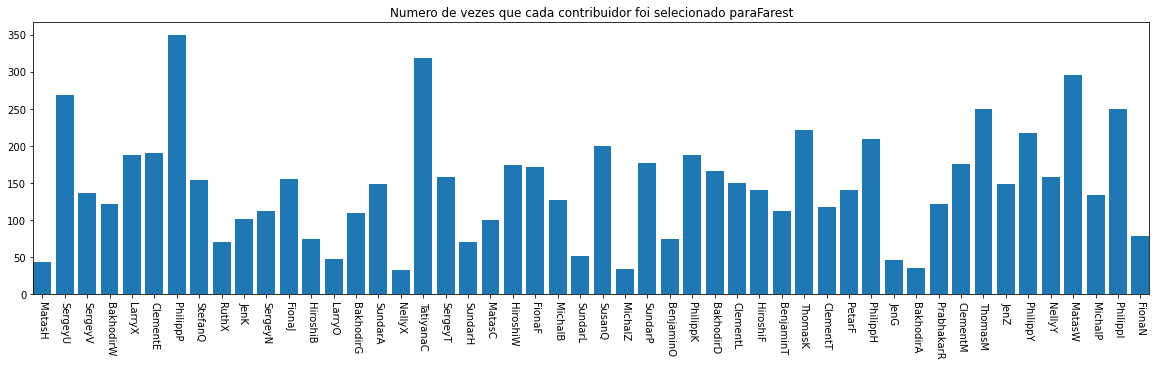

In [84]:
datasets = [ read_dataset(dataset_b) ]
instance = [ "B" ]

solutions = []
scores = []

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

# for data, PO in zip(datasets, priority_order, strict=False):
for i in range(len(instance)):
  for j in priority_order:
    for k in contributor_order:
      ip, maxd, solution, totalScore, plotx, ploty = solve(datasets[i], j, k)
      solutions.append((ip, maxd, instance[i], k, j, totalScore))
      print((len(ip), maxd, instance[i], k, j, totalScore))
      imprime(plotx, ploty)
      plota_graficos(datasets[i], ip, maxd, solution, totalScore, plotx, ploty, j, k)

#for i in solutions:
#  print(i)

In [85]:
dataset_x = dataset_a
instance = "A"

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

num_times = 3

for _ in range(num_times):
    solutions = []
    for j in priority_order:
        for k in contributor_order:
            ip, maxd, solution, totalScore, plotx, ploty = solve(read_dataset(dataset_x), j, k)
            solutions.append((ip, maxd, read_dataset(dataset_x), k, j, totalScore))
            #print((len(ip), maxd, instance, k, j, totalScore))
            #imprime(plotx, ploty)
            #plota_graficos(datasets[i], ip, maxd, solution, totalScore, plotx, ploty, j, k)
            
    solutions.sort(key=lambda a: a[-1], reverse = True)
    for sol in solutions:
        print((len(sol[0]), sol[1], instance, sol[3], sol[4], sol[-1]))
    print()

(0, 40, 'A', 'First_to_find', 'SPT', 33)
(0, 40, 'A', 'Nearest', 'SPT', 33)
(0, 40, 'A', 'Farest', 'SPT', 33)
(0, 40, 'A', 'First_to_find', 'EDD', 33)
(0, 40, 'A', 'Nearest', 'EDD', 33)
(0, 40, 'A', 'Farest', 'EDD', 33)
(0, 40, 'A', 'First_to_find', 'MST', 33)
(0, 40, 'A', 'Nearest', 'MST', 33)
(0, 40, 'A', 'Farest', 'MST', 33)
(0, 40, 'A', 'First_to_find', 'CR', 33)
(0, 40, 'A', 'Nearest', 'CR', 33)
(0, 40, 'A', 'Farest', 'CR', 33)
(0, 40, 'A', 'First_to_find', 'SLACK', 33)
(0, 40, 'A', 'Nearest', 'SLACK', 33)
(0, 40, 'A', 'Farest', 'SLACK', 33)
(0, 40, 'A', 'First_to_find', 'MANPOWER', 33)
(0, 40, 'A', 'Nearest', 'MANPOWER', 33)
(0, 40, 'A', 'Farest', 'MANPOWER', 33)
(2, 40, 'A', 'First_to_find', 'LPT', 20)
(2, 40, 'A', 'Nearest', 'LPT', 20)
(2, 40, 'A', 'Farest', 'LPT', 20)

(0, 40, 'A', 'First_to_find', 'SPT', 33)
(0, 40, 'A', 'Nearest', 'SPT', 33)
(0, 40, 'A', 'Farest', 'SPT', 33)
(0, 40, 'A', 'First_to_find', 'EDD', 33)
(0, 40, 'A', 'Nearest', 'EDD', 33)
(0, 40, 'A', 'Farest', 'E

In [86]:
dataset_x = dataset_b
instance = "B"

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

num_times = 3

for _ in range(num_times):
    solutions = []
    for j in priority_order:
        for k in contributor_order:
            ip, maxd, solution, totalScore, plotx, ploty = solve(read_dataset(dataset_x), j, k)
            solutions.append((ip, maxd, read_dataset(dataset_x), k, j, totalScore))
            #print((len(ip), maxd, instance, k, j, totalScore))
            #imprime(plotx, ploty)
            #plota_graficos(datasets[i], ip, maxd, solution, totalScore, plotx, ploty, j, k)
            
    solutions.sort(key=lambda a: a[-1], reverse = True)
    for sol in solutions:
        print((len(sol[0]), sol[1], instance, sol[3], sol[4], sol[-1]))
    print()

(27, 37740, 'B', 'First_to_find', 'MST', 800991)
(27, 37740, 'B', 'First_to_find', 'CR', 800991)
(27, 37740, 'B', 'First_to_find', 'MANPOWER', 800990)
(27, 37740, 'B', 'First_to_find', 'SPT', 800981)
(27, 37740, 'B', 'Farest', 'LPT', 800981)
(27, 37740, 'B', 'First_to_find', 'SLACK', 800973)
(27, 37740, 'B', 'First_to_find', 'LPT', 800963)
(27, 37740, 'B', 'Nearest', 'MANPOWER', 800913)
(27, 37740, 'B', 'Farest', 'MANPOWER', 800913)
(27, 37740, 'B', 'First_to_find', 'EDD', 800911)
(28, 37740, 'B', 'Nearest', 'MST', 769472)
(28, 37740, 'B', 'Farest', 'MST', 769472)
(28, 37740, 'B', 'Nearest', 'SPT', 769462)
(28, 37740, 'B', 'Farest', 'SPT', 769462)
(28, 37740, 'B', 'Nearest', 'EDD', 769445)
(28, 37740, 'B', 'Farest', 'EDD', 769445)
(28, 37740, 'B', 'Nearest', 'SLACK', 769445)
(28, 37740, 'B', 'Farest', 'SLACK', 769445)
(28, 37740, 'B', 'Nearest', 'CR', 769442)
(28, 37740, 'B', 'Farest', 'CR', 769442)
(28, 37740, 'B', 'Nearest', 'LPT', 769418)

(24, 37740, 'B', 'First_to_find', 'CR', 855

In [87]:
dataset_x = dataset_c
instance = "C"

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

num_times = 3

for _ in range(num_times):
    solutions = []
    for j in priority_order:
        for k in contributor_order:
            ip, maxd, solution, totalScore, plotx, ploty = solve(read_dataset(dataset_x), j, k)
            solutions.append((ip, maxd, read_dataset(dataset_x), k, j, totalScore))
            #print((len(ip), maxd, instance, k, j, totalScore))
            #imprime(plotx, ploty)
            #plota_graficos(datasets[i], ip, maxd, solution, totalScore, plotx, ploty, j, k)
            
    solutions.sort(key=lambda a: a[-1], reverse = True)
    for sol in solutions:
        print((len(sol[0]), sol[1], instance, sol[3], sol[4], sol[-1]))
    print()

(898, 133826, 'C', 'First_to_find', 'SPT', 199220)
(895, 133826, 'C', 'Farest', 'SPT', 197527)
(919, 133826, 'C', 'First_to_find', 'LPT', 196015)
(900, 133826, 'C', 'Nearest', 'MST', 186273)
(920, 133826, 'C', 'Nearest', 'LPT', 182793)
(894, 133826, 'C', 'Nearest', 'SPT', 182195)
(921, 133826, 'C', 'Farest', 'LPT', 180357)
(898, 133826, 'C', 'Farest', 'MST', 174488)
(894, 133826, 'C', 'First_to_find', 'MST', 172894)
(905, 133826, 'C', 'Nearest', 'EDD', 159455)
(909, 133826, 'C', 'Nearest', 'SLACK', 155104)
(912, 133826, 'C', 'First_to_find', 'CR', 154976)
(908, 133826, 'C', 'Farest', 'EDD', 153959)
(910, 133826, 'C', 'First_to_find', 'SLACK', 144622)
(902, 133826, 'C', 'First_to_find', 'MANPOWER', 142649)
(907, 133826, 'C', 'Farest', 'SLACK', 141658)
(909, 133826, 'C', 'Nearest', 'CR', 140028)
(912, 133826, 'C', 'Farest', 'CR', 139636)
(902, 133826, 'C', 'First_to_find', 'EDD', 139190)
(902, 133826, 'C', 'Farest', 'MANPOWER', 138971)
(899, 133826, 'C', 'Nearest', 'MANPOWER', 122929)



KeyboardInterrupt: 